In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten,Dropout, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error as mse
from functions_learning import *
from feed_data import data_extract
from tensorflow import keras
from keras import layers

2024-04-14 14:35:10.194702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 14:35:10.929066: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 14:35:10.939680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-14 14:35:10.939708: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
def plot_predictions1(model, X, y, start=0, end=100):
    prediction = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':prediction, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.title("Predictions")
    plt.show()
    mse_v = mse(y, prediction)
    return mse_v


def plot_train_history(history):
    plt.plot(history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss History')
    plt.show()
    
def fit_model(model, cp, epochs, xt, yt, xv, yv):
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])
    history = model.fit(xt, yt, validation_data=(xv, yv), epochs=epochs, callbacks=[cp], verbose=0)
    return model, history

def save_history(history, fname):
    training_loss = history.history['loss']
    validation_loss = history.history.get('val_loss', None)  # Handle optional key
    training_acc = history.history.get('accuracy', None)  # Handle optional key
    validation_acc = history.history.get('val_accuracy', None)  # Handle optional key

    # Create a dictionary
    history_data = {
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'training_accuracy': training_acc,
        'validation_accuracy': validation_acc}
    history_df = pd.DataFrame(history_data)
    history_df.to_csv(f"epochs{epochs}/history_{fname}.csv")
    

## Data Format

In [3]:
data = pd.read_csv("data/LocationD.csv")
data = data.drop(columns=["Unnamed: 0", "Date"])
data.head()

,TempD,pHD,ECD,DOD,BODD,TND
0,21.40,8.48,1695,2.59,27.93,1.27
1,20.75,8.44,1773,2.64,27.86,1.19
2,21.17,8.45,1737,2.61,27.71,1.23
3,21.20,8.36,1743,2.67,27.15,1.12
4,20.81,8.48,1787,2.68,27.19,1.13


In [4]:
data = data.drop(columns="ECD")
data.head()

,TempD,pHD,DOD,BODD,TND
0,21.40,8.48,2.59,27.93,1.27
1,20.75,8.44,2.64,27.86,1.19
2,21.17,8.45,2.61,27.71,1.23
3,21.20,8.36,2.67,27.15,1.12
4,20.81,8.48,2.68,27.19,1.13


In [5]:
target_column = "BODD"
features = data.drop(target_column, axis=1)
target = data[target_column]

In [6]:
X = []
y = []
for i in range(5, len(features)):
    X.append(features.iloc[i-5:i, :].values.ravel())  # Flatten features
    y.append(target.iloc[i])

X = np.array(X)
y = np.array(y)

In [7]:
X[0], y[0]

(array([21.4 ,  8.48,  2.59,  1.27, 20.75,  8.44,  2.64,  1.19, 21.17,
         8.45,  2.61,  1.23, 21.2 ,  8.36,  2.67,  1.12, 20.81,  8.48,
         2.68,  1.13]),
 27.06)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [9]:
x_train.shape, y_train.shape

((230, 20), (230,))

In [10]:
xt = x_train.copy()
xt = xt.reshape(230,20,1)
xt.shape

(230, 20, 1)

x_test = x_test.reshape(72, 25, 1)
x_test.shape

In [11]:
window_size = 5

def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=xt)
target = y_train[window_size - 1:].flatten()

In [12]:
moving_avg_data.shape, target.shape

((226, 20, 1), (226,))

In [13]:
epochs = 50
x_train = xt.copy()
input_shape = (20,1)

# General Model

### CNN

2024-04-14 14:35:16.925780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-14 14:35:16.926305: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-14 14:35:16.926348: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2024-04-14 14:35:16.926942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


INFO:tensorflow:Assets written to: epochs50/cnn/assets


3/3 [==============================] - 0s 11ms/step


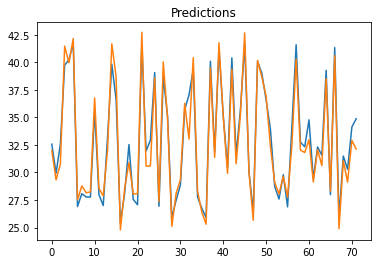

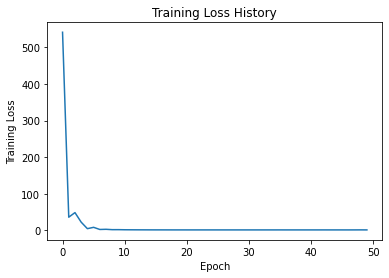

In [14]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

'''
model = keras.Sequential([
  keras.layers.Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
  keras.layers.MaxPooling1D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dense(1) 
])
'''

mname = f"epochs{epochs}/cnn"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)
cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "cnn")

In [15]:
cnn_mse

1.1769899634469594

### GRU

INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


INFO:tensorflow:Assets written to: epochs50/gru/assets


3/3 [==============================] - 1s 47ms/step


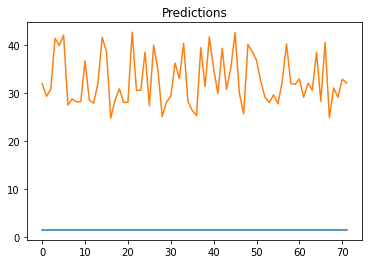

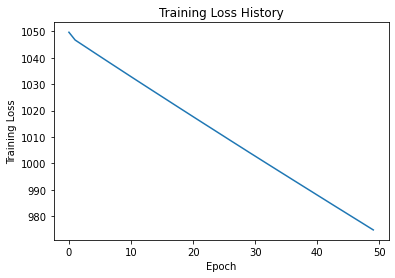

In [16]:
model = keras.Sequential([
    layers.GRU(units=512, return_sequences=True, input_shape=input_shape),
    layers.Dense(units=32),
    layers.GRU(units=2, activation="tanh"),
    layers.Dense(1) 
  ])

mname = f"epochs{epochs}/gru"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)
gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "gru")

In [17]:
gru_mse

1005.0118175967206

### LSTM

INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


INFO:tensorflow:Assets written to: epochs50/lstm/assets


3/3 [==============================] - 2s 31ms/step


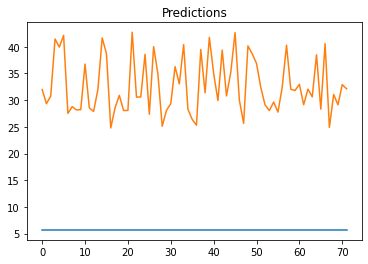

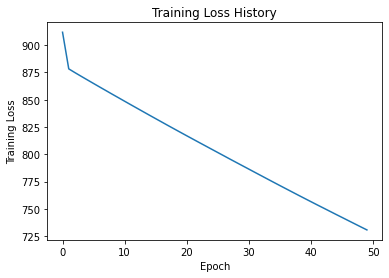

In [18]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(512))
model.add(Dense(8, "sigmoid"))
model.add(Dense(1, 'linear'))

mname = f"epochs{epochs}/lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "lstm")

In [19]:
lstm_mse

755.9265173651856

### RNN

INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


INFO:tensorflow:Assets written to: epochs50/rnn/assets


3/3 [==============================] - 0s 5ms/step


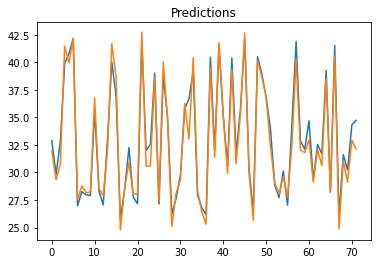

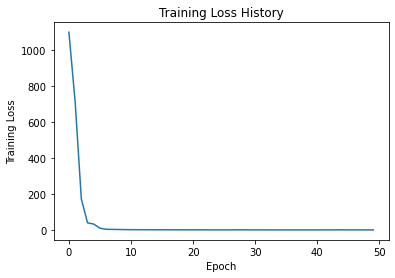

In [20]:
model = keras.Sequential([
    layers.SimpleRNN(units=128, input_shape=input_shape),
    layers.Dense(8),
    layers.Dense(1)
])


model = Sequential([
    SimpleRNN(50, input_shape=input_shape, activation='relu'),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/rnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "rnn")

In [21]:
rnn_mse

1.1224537770189567

# Moving Average

In [22]:
window_size = 5

def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=x_train)
target = y_train[window_size - 1:].flatten()

#### CNN

INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_cnn/assets


3/3 [==============================] - 0s 4ms/step


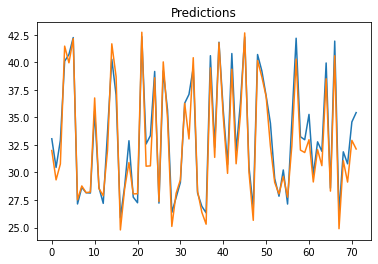

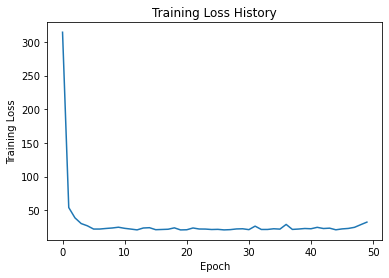

In [23]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model = keras.Sequential([
  keras.layers.Conv1D(256, kernel_size=3, activation="relu", input_shape=input_shape),
  keras.layers.MaxPooling1D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(128), 
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1) 
])



mname = f"epochs{epochs}/mavg_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, moving_avg_data, target,x_val, y_val)

mvg_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_cnn")

In [24]:
mvg_cnn_mse

1.6067412203167168

mvg_cnn_mse

#### GRU

INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_gru/assets


3/3 [==============================] - 1s 8ms/step


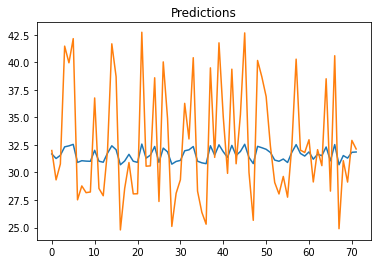

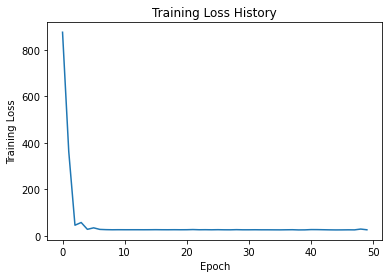

In [25]:
model = keras.Sequential([
    layers.GRU(units=128, input_shape=input_shape),
    layers.Dense(64),
    layers.Dense(8),
    layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,  moving_avg_data, target, x_val, y_val)

mvg_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_gru")

#### LSTM

INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_lstm/assets


3/3 [==============================] - 1s 8ms/step


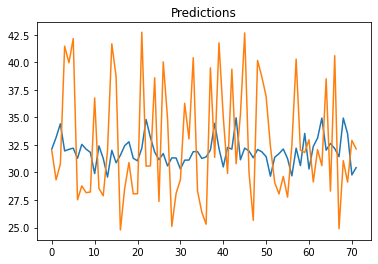

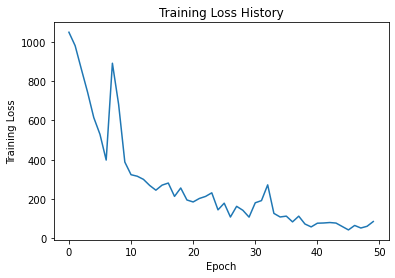

In [26]:
model = keras.Sequential([
  keras.layers.LSTM(units=128, return_sequences=True, input_shape=(input_shape)),  # First LSTM layer
  keras.layers.LSTM(units=64),  # Second LSTM layer
  layers.Dense(units=8),
  keras.layers.Dense(units=1)  # Output layer with 1 unit for single-value prediction
])

'''
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
'''

model = keras.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=input_shape),
    keras.layers.LSTM(50),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
  ])


mname = f"epochs{epochs}/mavg_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mvg_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_lstm")

In [27]:
mvg_lstm_mse

29.140336277371084

#### RNN

INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets
2024-04-14 15:05:54.836506: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_rnn/assets


3/3 [==============================] - 0s 7ms/step


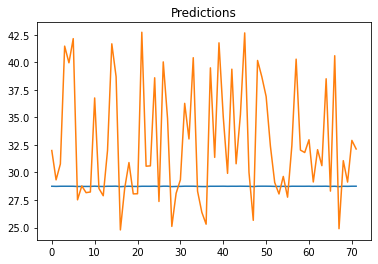

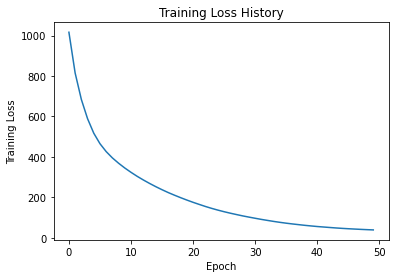

In [28]:
model = keras.Sequential([
    layers.SimpleRNN(units=64, activation="tanh", input_shape=input_shape),
    layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mvg_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_rnn")

In [29]:
mvg_rnn_mse

42.23971218612286

# AutoEncoder

### CNN

INFO:tensorflow:Assets written to: epochs50/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs50/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs50/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs50/autoencoder_cnn/assets


3/3 [==============================] - 0s 3ms/step


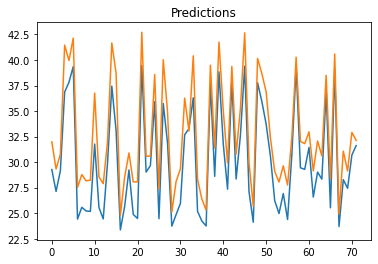

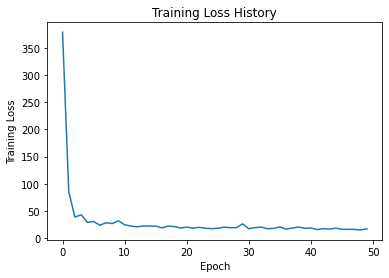

In [30]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(32, kernel_size=1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model = keras.Sequential([
  keras.layers.Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
  keras.layers.Dropout(0.2), 
  keras.layers.MaxPooling1D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dropout(0.4),  
  keras.layers.Dense(1)  
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/autoencoder_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

auto_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_cnn")

In [31]:
auto_cnn_mse

7.710770060390085

### GRU

INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/auto_gru/assets


3/3 [==============================] - 1s 7ms/step


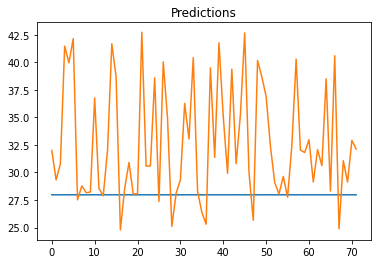

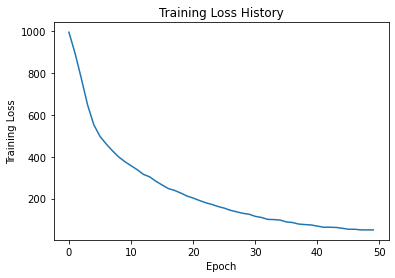

In [32]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_gru"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

auto_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_gru")

In [33]:
auto_gru_mse

48.97655909082211

### LSTM

INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/auto_lstm/assets


3/3 [==============================] - 1s 5ms/step


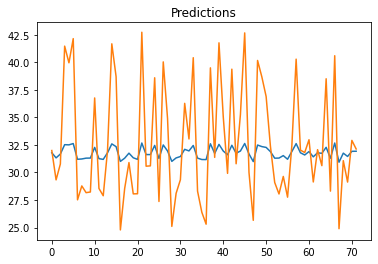

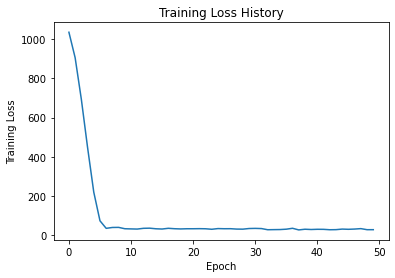

In [34]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dropout(0.3))
#model.add(RepeatVector(3))
#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Dense(8, 'relu'))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)


auto_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_lstm")

In [35]:
auto_lstm_mse

22.561946251762336

### RNN

INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/auto_rnn/assets


3/3 [==============================] - 0s 3ms/step


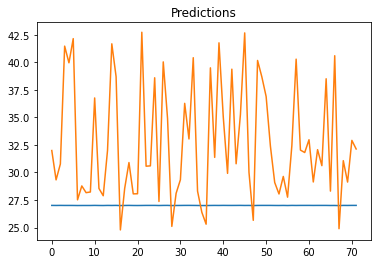

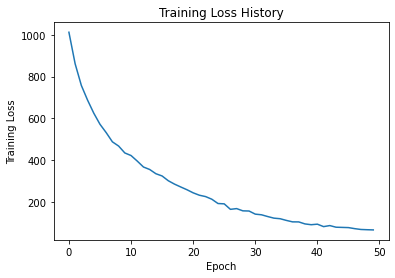

In [36]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(SimpleRNN(64))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)


auto_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_rnn")

In [37]:
auto_rnn_mse

59.031765807531116

# Moving Average with Encoder

### CNN

INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_cnn/assets


3/3 [==============================] - 0s 15ms/step


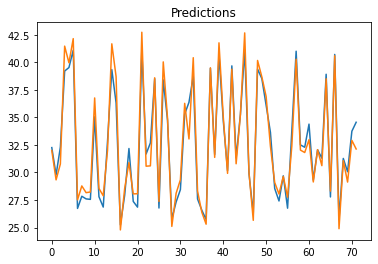

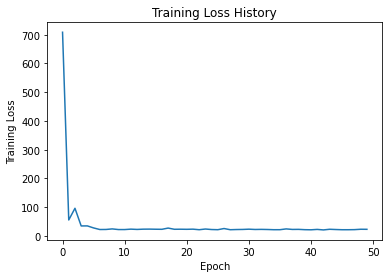

In [38]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, "relu"))
model.add(Dense(1, 'linear'))


model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_auto_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_auto_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_cnn")

In [39]:
mavg_auto_cnn_mse

1.1584270145733586

### RNN

INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_rnn/assets


3/3 [==============================] - 0s 6ms/step


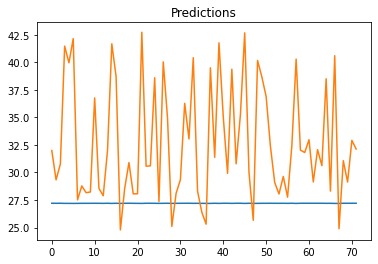

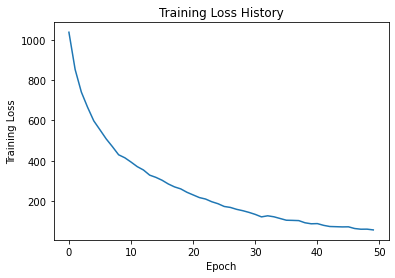

In [40]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(SimpleRNN(64))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_auto_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,moving_avg_data,target, x_val, y_val)

mavg_auto_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_rnn")

In [41]:
mavg_auto_rnn_mse

56.89599759308279

### GRU

INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_gru/assets


3/3 [==============================] - 1s 6ms/step


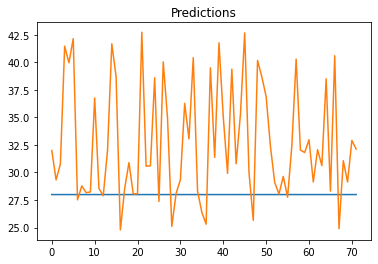

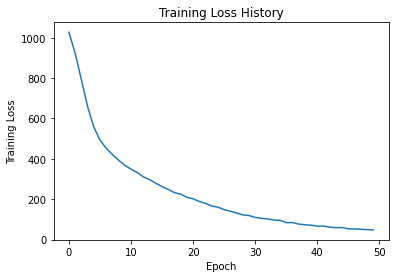

In [42]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_auto_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_auto_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_gru")

In [43]:
mavg_auto_gru_mse

48.79378787438155

### LSTM

INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_auto_lstm/assets


3/3 [==============================] - 1s 6ms/step


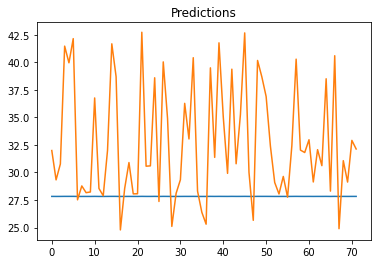

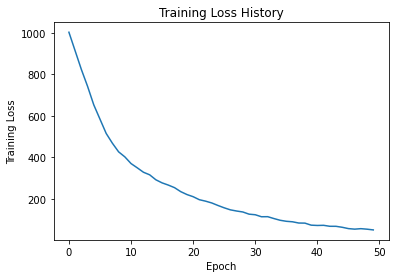

In [44]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dropout(0.3))
#model.add(RepeatVector(3))
#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.4))
#model.add(Dense(8, 'relu'))
#model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_auto_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,moving_avg_data, target, x_val, y_val)

mavg_auto_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_lstm")

In [45]:
mavg_auto_lstm_mse

50.37466625668795

# Hybrid

## General

### CNN LSTM

INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_lstm/assets


3/3 [==============================] - 1s 13ms/step


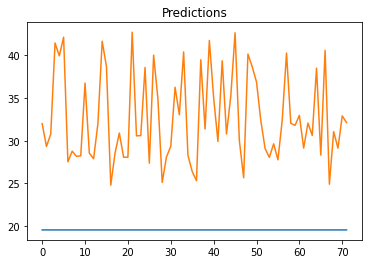

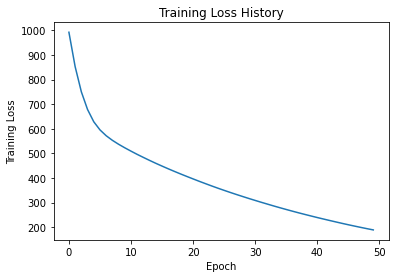

In [46]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(RepeatVector(n=input_shape[0]))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_lstm")

In [47]:
hybrid_cnn_lstm_mse

199.73097352977868

### RNN LSTM

INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_lstm/assets


3/3 [==============================] - 1s 8ms/step


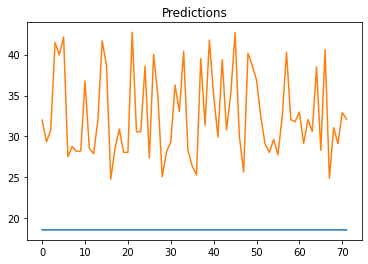

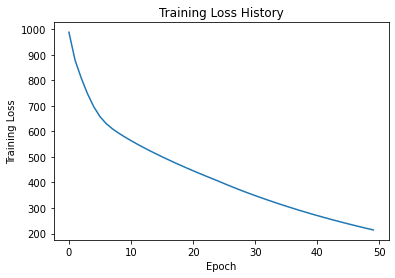

In [48]:
model = Sequential()
model.add(SimpleRNN(64,return_sequences=True, input_shape=input_shape))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_rnn_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_rnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_rnn_lstm")

In [49]:
hybrid_rnn_lstm_mse

225.4920920260274

### RNN GRU

INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_rnn_gru/assets


3/3 [==============================] - 1s 20ms/step


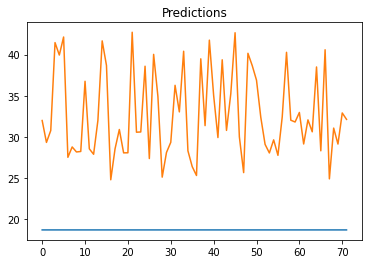

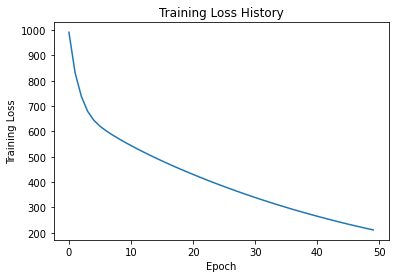

In [50]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_rnn_gru")

In [51]:
hybrid_rnn_gru_mse

222.7427303388057

### CNN GRU

INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_gru/assets


3/3 [==============================] - 1s 13ms/step


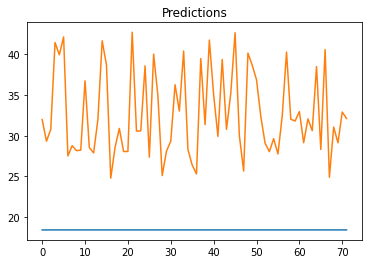

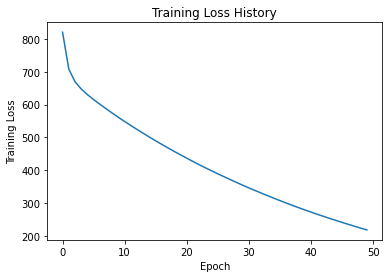

In [52]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())

model.add(RepeatVector(n=15))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_gru")

In [53]:
hybrid_cnn_gru_mse

230.2637625197552

### CNN RNN GRU

INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_cnn_rnn_gru/assets


3/3 [==============================] - 1s 10ms/step


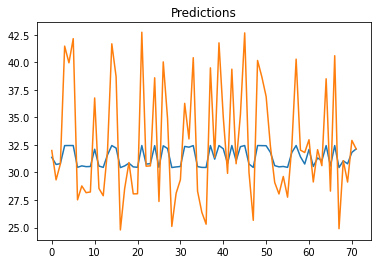

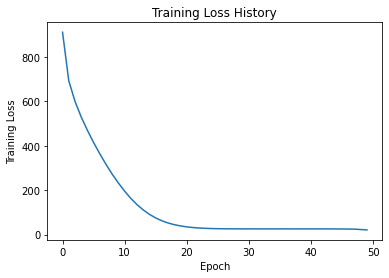

In [54]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(RepeatVector(n=15))
model.add(SimpleRNN(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_rnn_gru")

In [55]:
hybrid_cnn_rnn_gru_mse

21.125996055916985

### LSTM RNN GRU

INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/hybrid_lstm_rnn_gru/assets


3/3 [==============================] - 1s 21ms/step


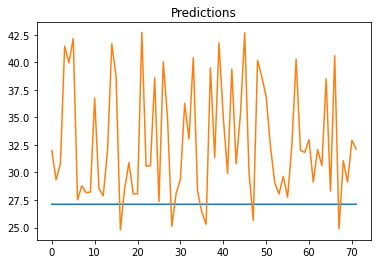

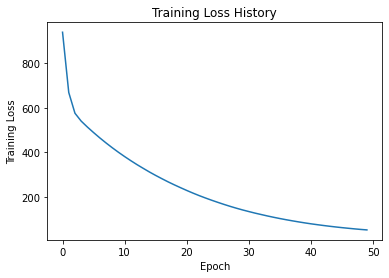

In [56]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(LSTM(128, return_sequences=True))
model.add(GRU(64))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_lstm_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history =fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_lstm_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_lstm_rnn_gru")

In [57]:
hybrid_lstm_rnn_gru_mse

57.83419874943944

## Moving Average

### CNN LSTM

INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_lstm/assets


3/3 [==============================] - 2s 9ms/step


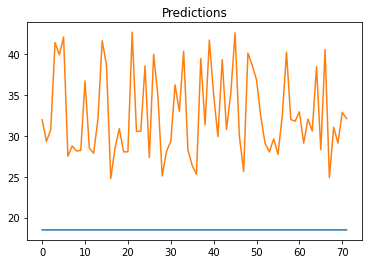

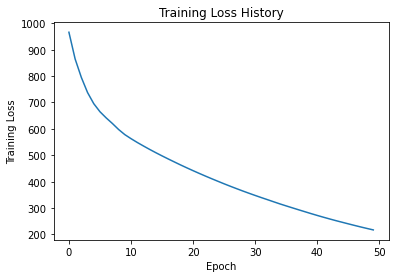

In [58]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(RepeatVector(n=input_shape[0]))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_hybrid_cnn_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_lstm")

In [59]:
mavg_hybrid_cnn_lstm_mse

228.4692488283008

### RNN LSTM

INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_lstm/assets


3/3 [==============================] - 1s 21ms/step


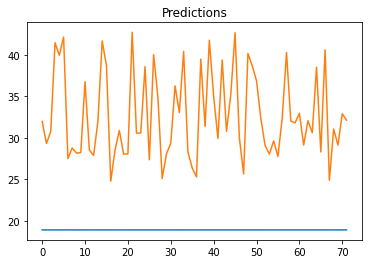

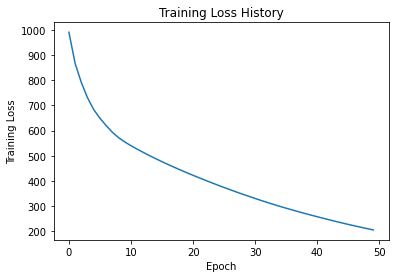

In [60]:
model = Sequential()
model.add(SimpleRNN(64,return_sequences=True, input_shape=input_shape))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_rnn_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_rnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_rnn_lstm")

In [61]:
mavg_hybrid_rnn_lstm_mse

216.369677392018

### RNN GRU

INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_rnn_gru/assets


3/3 [==============================] - 1s 8ms/step


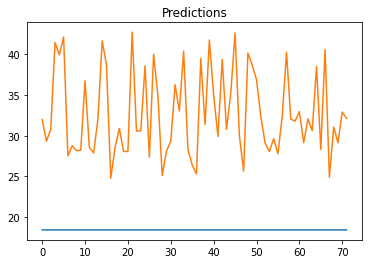

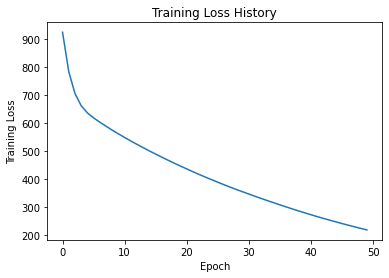

In [62]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_rnn_gru")

In [63]:
mavg_hybrid_rnn_gru_mse

230.43132383269293

### CNN GRU

INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_gru/assets


3/3 [==============================] - 1s 11ms/step


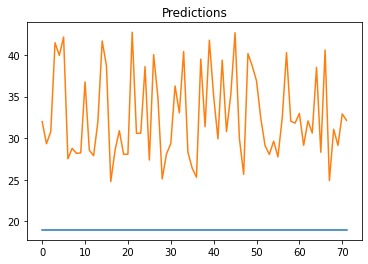

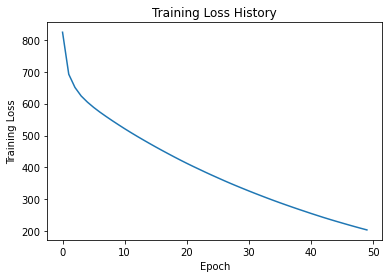

In [64]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(RepeatVector(n=15))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_cnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_gru")

In [65]:
mavg_hybrid_cnn_gru_mse

214.79940510414565

### CNN RNN GRU

INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_cnn_rnn_gru/assets


3/3 [==============================] - 1s 19ms/step


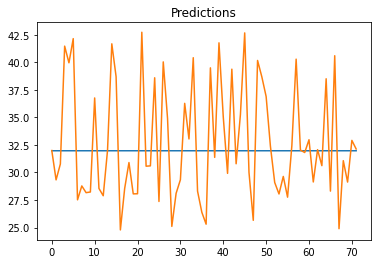

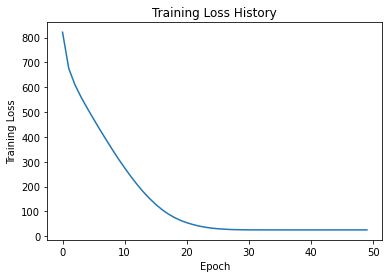

In [66]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n=15))
model.add(SimpleRNN(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_cnn_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_rnn_gru")

In [67]:
mavg_hybrid_cnn_rnn_gru_mse

27.229707711894306

### RNN LSTM GRU

INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs50/mavg_hybrid_lstm_rnn_gru/assets


3/3 [==============================] - 1s 7ms/step


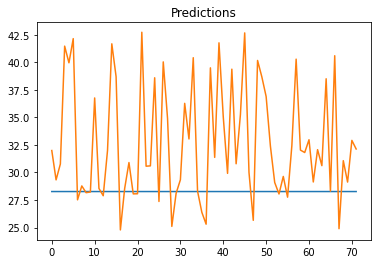

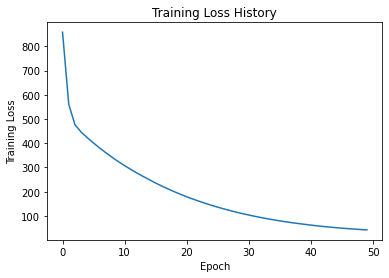

In [68]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(LSTM(128, return_sequences=True))
model.add(GRU(64))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_lstm_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target,x_val, y_val)

mavg_hybrid_lstm_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_lstm_rnn_gru")

In [69]:
mavg_hybrid_lstm_rnn_gru_mse

46.29384228837692

# MSE

In [70]:
gen = ["General" for _ in range(0,4)]
ma = ["MA" for _ in range(0,4)]
ae = ["AE" for _ in range(0,4)]
ma_ae = ["MA AE" for _ in range(0,4)]
hy = ["HY" for _ in range(0,6)]
ma_hy = ["MA HY" for _ in range(0,6)]

In [71]:
model_cat = []

for a in gen:
    model_cat.append(a)
for a in ma:
    model_cat.append(a)
for a in ae:
    model_cat.append(a)
for a in ma_ae:
    model_cat.append(a)
for a in hy:
    model_cat.append(a)
for a in ma_hy:
    model_cat.append(a)

In [72]:
mse_list = [cnn_mse, rnn_mse, gru_mse, lstm_mse,
            mvg_cnn_mse, mvg_rnn_mse, mvg_gru_mse, mvg_lstm_mse,
            auto_cnn_mse, auto_rnn_mse, auto_gru_mse, auto_lstm_mse,
            mavg_auto_cnn_mse, mavg_auto_rnn_mse, mavg_auto_gru_mse, mavg_auto_lstm_mse,
            hybrid_cnn_lstm_mse, hybrid_lstm_rnn_gru_mse,hybrid_cnn_rnn_gru_mse,hybrid_cnn_gru_mse,
            hybrid_rnn_gru_mse,hybrid_rnn_lstm_mse,
            mavg_hybrid_cnn_lstm_mse, mavg_hybrid_lstm_rnn_gru_mse,mavg_hybrid_cnn_rnn_gru_mse,
            mavg_hybrid_cnn_gru_mse,mavg_hybrid_rnn_gru_mse,mavg_hybrid_rnn_lstm_mse]

model_n = ["CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "LSTM", "LSTM RNN GRU" ,"CNN RNN GRU","CNN GRU",
           "RNN GRU","RNN LSTM",
           "CNN LSTM", "LSTM RNN GRU","CNN RNN GRU",
           "CNN GRU","RNN GRU","RNN LSTM"
          ]

msedf = pd.DataFrame({
    "ModelCat": model_cat,
    "Model": model_n,
    "MSE": mse_list
})

rmse = np.sqrt(msedf.MSE)
msedf["RMSE"] = rmse

In [73]:
msedf

,ModelCat,Model,MSE,RMSE
0,General,CNN,1.176990,1.084892
1,General,RNN,1.122454,1.059459
2,General,GRU,1005.011818,31.701921
3,General,LSTM,755.926517,27.494118
4,MA,CNN,1.606741,1.267573
5,MA,RNN,42.239712,6.499209
6,MA,GRU,22.398762,4.732733
7,MA,LSTM,29.140336,5.398179
8,AE,CNN,7.710770,2.776827
9,AE,RNN,59.031766,7.683213


In [74]:
msedf.to_csv("msedf.csv", index= False)

<AxesSubplot:xlabel='Model'>

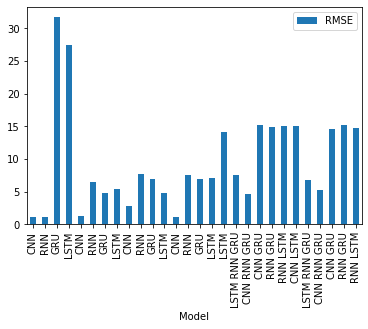

In [75]:
msedf.plot("Model", "RMSE", kind= "bar")

In [76]:
np.save(f"epochs{epochs}/x_train.npy", x_train)
np.save(f"epochs{epochs}/y_train.npy", y_train)
np.save(f"epochs{epochs}/x_test.npy", x_test)
np.save(f"epochs{epochs}/y_test.npy", y_test)
np.save(f"epochs{epochs}/x_val.npy", x_val)
np.save(f"epochs{epochs}/y_val.npy", y_val)